# Проект «Прогнозирование оттока клиентов банка»

### Описание проекта
Из «Бета-Банка» каждый месяц стали уходить клиенты. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
<p></p>

 **Задача проекта** —  построить модель, прогнозирующую уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.



**Источник данных**: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)



## Импорт и изучение данных

Импортируем все необходимые библиотеки

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import OneHotEncoder, StandardScaler

Импортируем датасет для работы и выводим первые 5 строк.

In [ ]:
try:
    df = pd.read_csv('.../Churn.csv', sep=',', index_col=0)
except:
    df = pd.read_csv('...Churn.csv', sep=',', index_col=0)

df.head(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Признаки:**
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата
<p></p>

**Целевой признак**:
- `Exited` — факт ухода клиента.


### Изучение данных

Изучим данные. Для начала оценим пропуски.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1.1+ MB


- 909 значений пропущено в колонке `Tenure`
- В остальных колонках пропусков нет

Проверим полные дубликаты данных.


In [ ]:
df.duplicated().sum()

0

Дубликатов нет.

### Изучение распределения

Посмотрим на распределения, чтобы проверить, что предлставленные данные корректы и не содержат аномалий.

In [ ]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


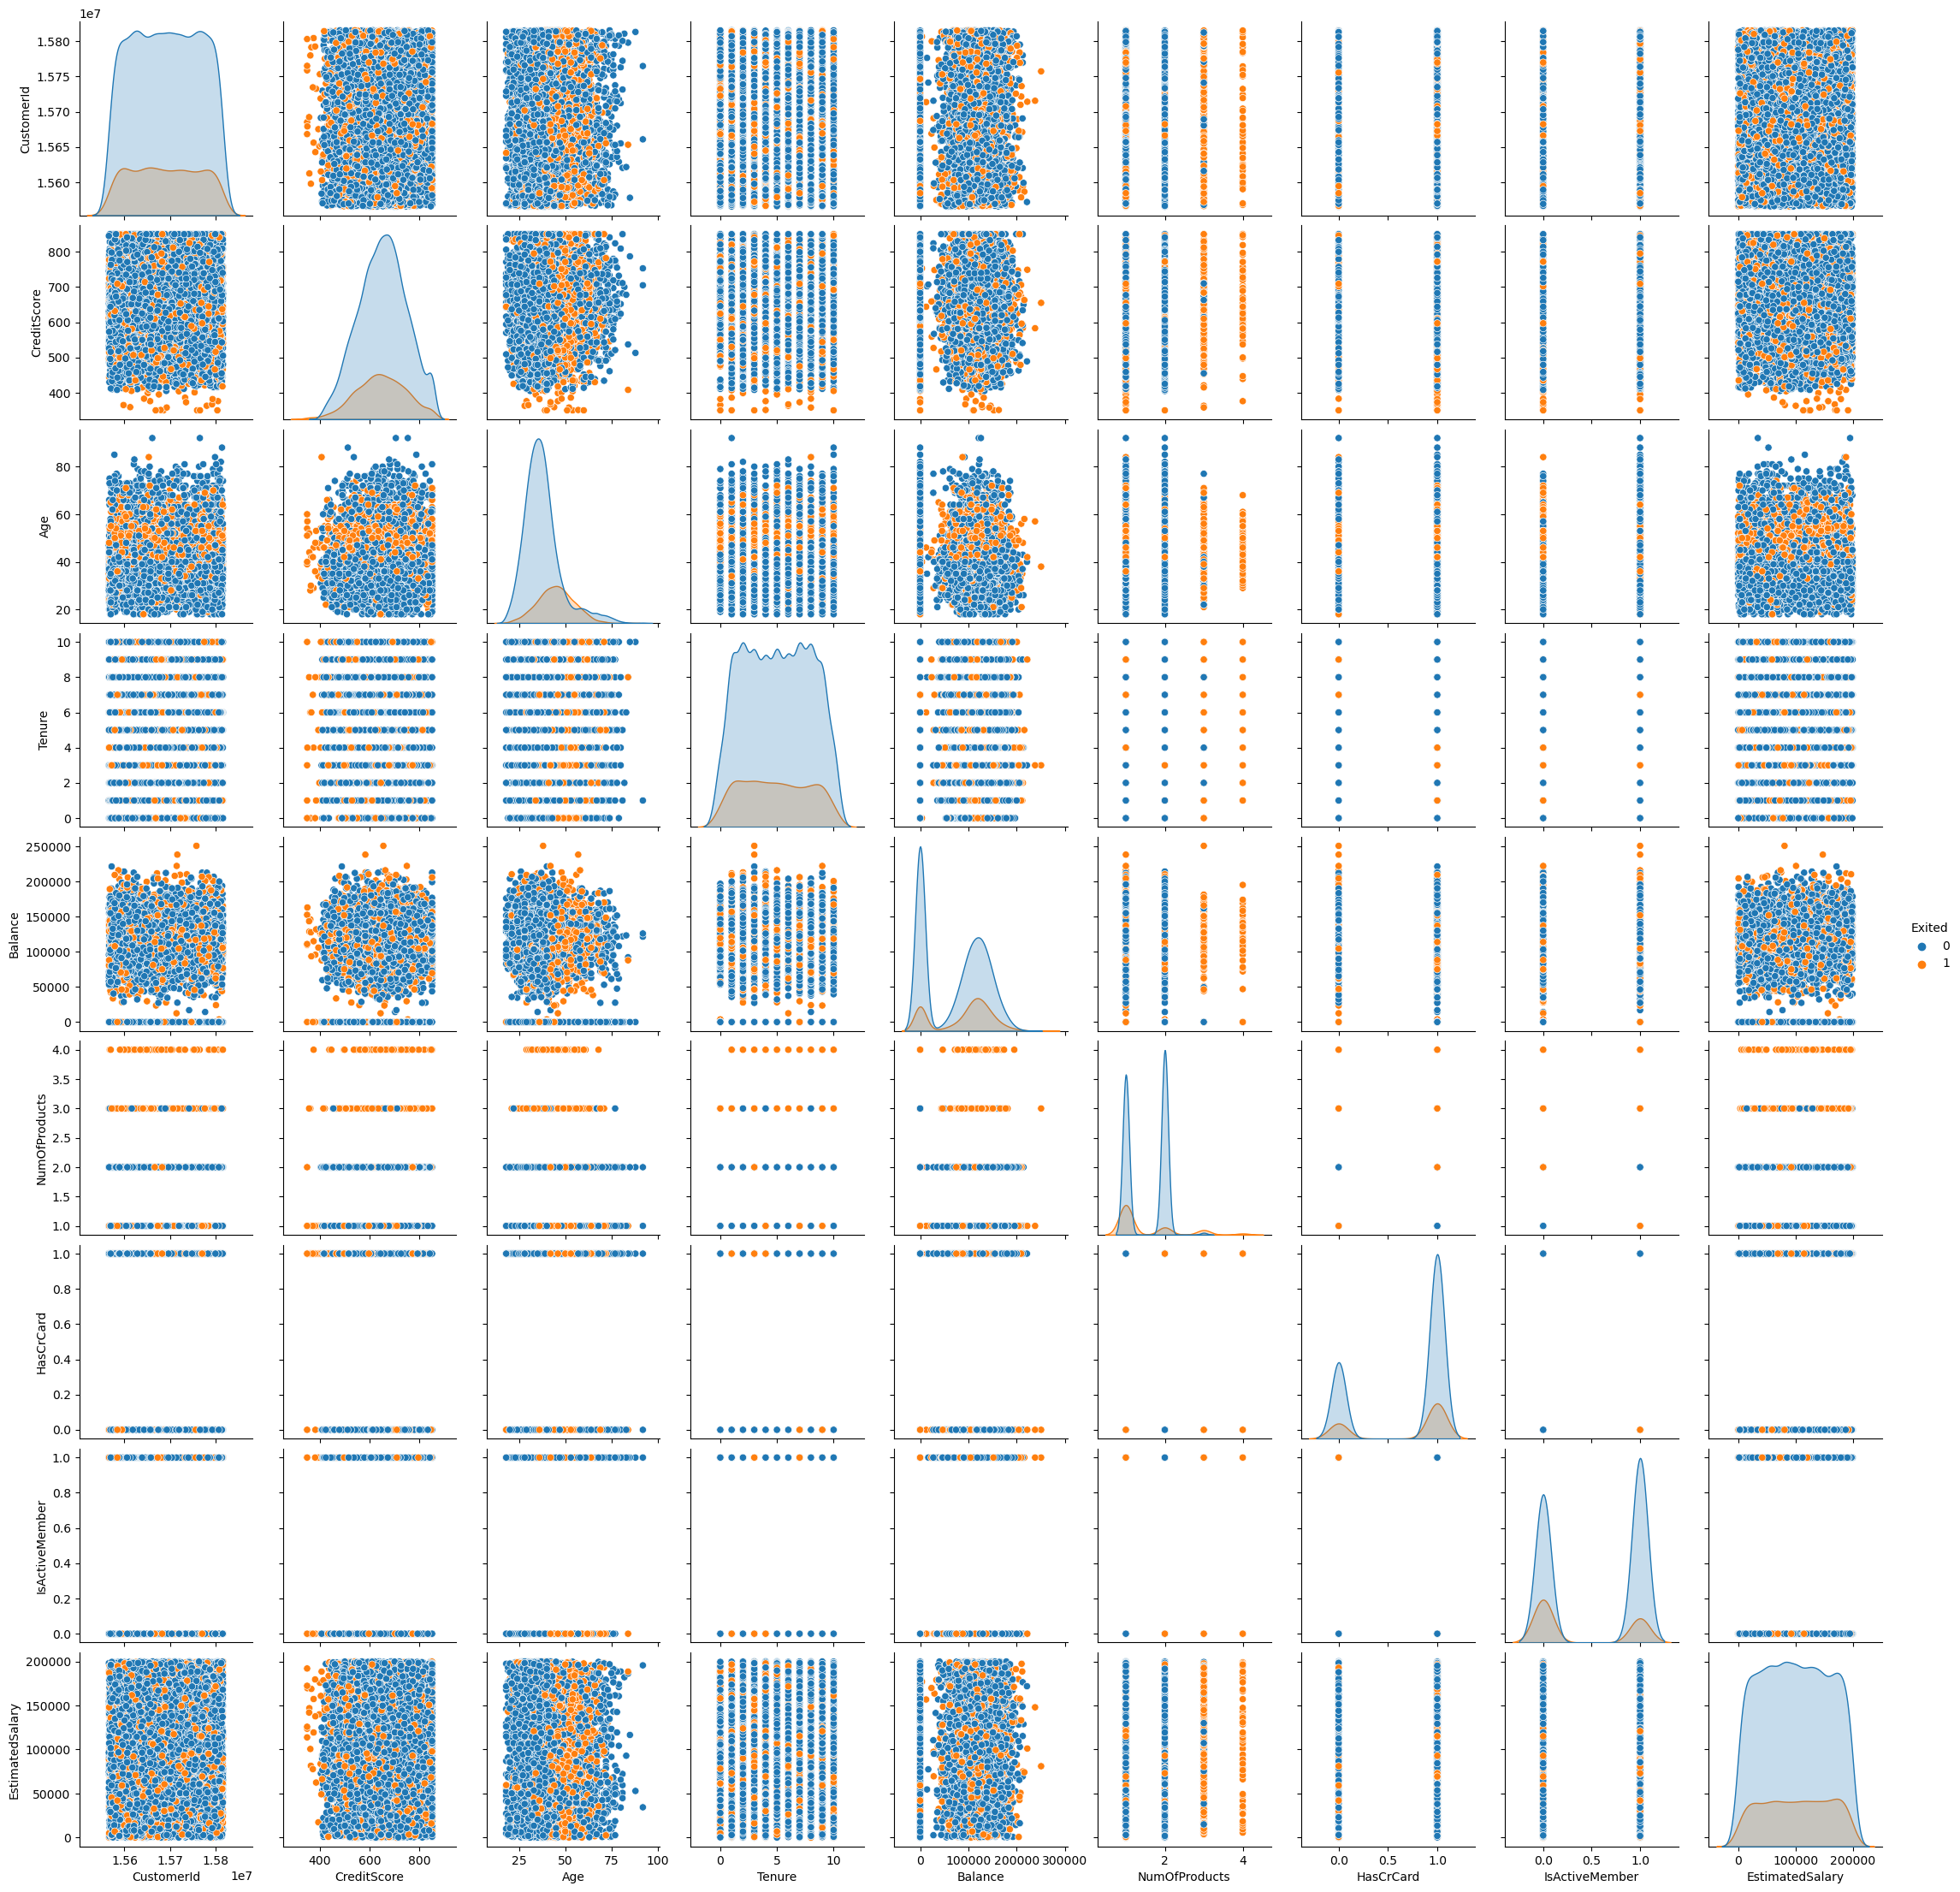

In [ ]:
sns.pairplot(df, hue='Exited');

- Распределения смотрятся корректно.
- Заметно, что в выборке существует дисбаланс. Объектов 1 класса существенно меньше, чем объектов 0 класса.
- В данных можно обнаружить интересные закономерности. Самое заметное — нелинейная связь класса от возраста. Посмотрим подробнее.

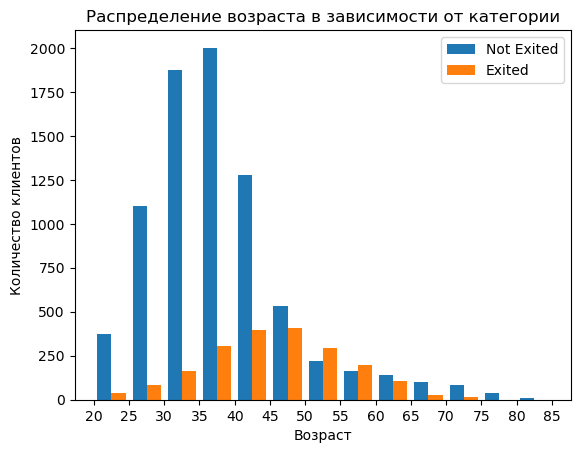

In [ ]:
bins = range(20,90,5)

plt.hist([df[df['Exited'] == 0]['Age'], df[df['Exited'] == 1]['Age']], bins=bins, label = ['Not Exited', 'Exited'])
plt.legend()
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.title('Распределение возраста в зависимости от категории')
plt.xticks(range(20, 90, 5))
plt.show()

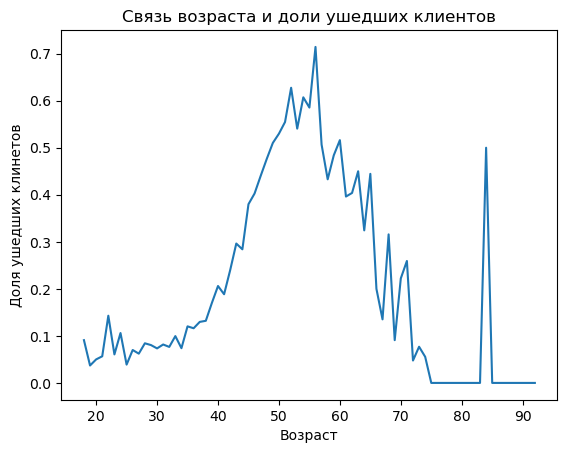

In [ ]:
age_groups = df.groupby('Age')['Exited'].mean()
plt.plot(age_groups)
plt.xlabel('Возраст')
plt.ylabel('Доля ушедших клинетов')
plt.title('Связь возраста и доли ушедших клиентов')
plt.show()

- В возрасте 35 лет количество ушедших к общему колучеству клиентов составляет около 0,1
- В возрасте 50 лет составляет примерно 0,5, в возрасте поднимается до 0,7 и начинает снижаться.
- Пика графика в районе 83 лет связан с малым количеством записей в данных.

Продолжим изучать данные и посмотрим на категориальные переменные `Geography` и
`Gender`.

In [ ]:
df['Geography'].value_counts().reset_index().style.format({'Exited': '{:.2%}'})

,index,Geography
0,France,5014
1,Germany,2509
2,Spain,2477


В датасете представлены всего три страны: Франция, Германия, Испания. Посмотрим, есть ли отличия среди стран в проценте уходящих клиентов.

In [ ]:
df.groupby('Geography')['Exited'].mean().reset_index().style.format({'Exited': '{:.2%}'})

,Geography,Exited
0,France,16.15%
1,Germany,32.44%
2,Spain,16.67%


Доля ушедших клиентов среди немцев почти в два раза выше, чем в остальных странах! Это  не связано с количество немцев, их не больше всех остальных.
Посмотрим на распределение по полу в датасете.

In [ ]:
df['Gender'].value_counts().reset_index().style.format({'Exited': '{:.2%}'})

,index,Gender
0,Male,5457
1,Female,4543


In [ ]:
df.groupby('Gender')['Exited'].mean().reset_index().style.format({'Exited': '{:.2%}'})

,Gender,Exited
0,Female,25.07%
1,Male,16.46%


Ради интереса посмотрим, как часто уходят из банка немецкие женщины после 40. И сравним их с, например, испанскими мужчинами до 40.

In [ ]:
df[(df['Geography'] == 'Germany') & (df['Gender'] == 'Female') & (df['Age'] > 40)]['Exited'].mean()

0.576171875

In [ ]:
df[(df['Geography'] == 'Spain') & (df['Gender'] == 'Male') & (df['Age'] < 40)]['Exited'].mean()

0.06904487917146145

Передадим отделу маркетингу информацию о том, что у нашего продукта есть проблемы с популярностью среди немецких женщин, а для себя зафикисируем, что:
- данные выглядят корректно
- для машинного обучения нужно будет кодировать категореальные переменные.


Проверим баланс классов.

In [ ]:
balance = df['Exited'].value_counts().to_frame()
balance['Percent'] = df['Exited'].value_counts(normalize=True).to_frame()*100
print(balance)

   Exited  Percent
0    7963    79.63
1    2037    20.37


Наблюдается несбалансированность классов. Мы будем обучать модель на исходных данных, затем попробуем преодолеть несбалансированность и обучим еще раз. Посмотрим на результаты позже.

**Промежуточные выводы**:
- В выборке существует дисбаланс. Объектов 1 класса существенно меньше, чем объектов 0 класса.
- На первый взгляд мы не наблюдаем аномалий в данных и существенных выбросов. Например, по возрасту минимальный возраст 18, максимальный 92, что может быть правдой.
- В колонке `Tenure` есть пропуски
- Можно передать маркетологам, чтобы в в первую очередь нужно работать над удержанием людей в возрасте 40+. Также среди других странн значительно более высокий процент уходов у клиентов из Германии.

## Подготовка данных

В колонке есть столбцы: `CustomerId` — уникальный идентификатор клиента и
`Surname` — фамилия. Они будут бесполезны для обучения модели, поэтому удалим их из датасета.

In [ ]:
df = df.drop(columns = ['CustomerId', 'Surname'], axis = 1)
df.head(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Значение в столбце `Tenure` заменим на медианное значение. Т.к. медиана более устойчива к выбросам.

In [ ]:
df['Tenure'] = df['Tenure']. fillna(df['Tenure'].median())

Проверим, что пропусков нет.

In [ ]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

### Разделение на выборки, масштабирование и кодирование переменных.

Разделим выборки на тренировочную, валидационную и тестовую в пропорции 3:1:1.

In [ ]:
target = df['Exited']
features = df.drop('Exited', axis=1)

features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_and_test, target_valid_and_test, test_size=0.5, random_state=12345)

In [ ]:
samples = [features_train,target_train,features_valid, target_valid,features_test,target_test]

for sample in samples:
    sample.reset_index(inplace=True, drop=True)

In [ ]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 10)
(2000, 10)
(2000, 10)


Для обучения моделей напишем функцию на основе метода метода `StandardScaler()`

In [ ]:
numerical = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numerical])

def scaler(data, columns):

    data[columns] = scaler.transform(data[columns])
    return data



Масштабируем три полученные выборки

In [ ]:
features_train = scaler(features_train, numerical)
features_valid = scaler(features_valid, numerical)
features_test = scaler(features_test, numerical)

Используем метод `One Hot Encoding`, чтобы превести к двоичному значению данные в этих двух переменных:  `Geography` и `Gender` в каждом из наборов данных.

In [ ]:
features_train.reset_index(inplace=True, drop=True)
target_train.reset_index(inplace=True, drop=True)

enc = OneHotEncoder(drop='first')
X = features_train[['Geography', 'Gender']]
enc.fit(X)
array_encoded = enc.transform(X).toarray()
features_encoded = pd.DataFrame(array_encoded, columns=enc.get_feature_names_out(['Geography', 'Gender']))
features_train = features_train.drop(['Geography', 'Gender'], axis=1)
features_train = pd.concat([features_train, features_encoded], axis=1)

In [ ]:
features_train.shape


(6000, 11)

In [ ]:
features_valid.reset_index(inplace=True, drop=True)
target_valid.reset_index(inplace=True, drop=True)

X = features_valid[['Geography', 'Gender']]
array_encoded = enc.transform(X).toarray()
features_encoded = pd.DataFrame(array_encoded, columns=enc.get_feature_names_out(['Geography', 'Gender']))
features_valid = features_valid.drop(['Geography', 'Gender'], axis=1)
features_valid = pd.concat([features_valid, features_encoded], axis=1)

In [ ]:
features_valid.shape

(2000, 11)

In [ ]:
features_test.reset_index(inplace=True, drop=True)
target_test.reset_index(inplace=True, drop=True)

X = features_test[['Geography', 'Gender']]
array_encoded = enc.transform(X).toarray()
features_encoded = pd.DataFrame(array_encoded, columns=enc.get_feature_names_out(['Geography', 'Gender']))
features_test = features_test.drop(['Geography', 'Gender'], axis=1)
features_test = pd.concat([features_test, features_encoded], axis=1)

In [ ]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


**Промежуточные выводы**:
Подготовили данные к обучению моделей.
- Удалили колонки `CustomerId` и`Surname`, т.к. они не нужны нам для анализа
- Масштабировали признаки методом StandardScaler()
- Значние в столбце `Tenure` заменили на медианное значение.
- Разделили выборки на тренировочную, валидационную и тестовую в пропорции 3:1:1
- Использовали метод `One Hot encoding`, чтобы превести к двоичному значению данные в этих двух переменных: `Geography` и `Gender`.

## Обучение моделей

### Определение минимального порога работы модели

Для проверки модели на адекватность создадим модель "dummy" классификатора, использующего стратегию "most_frequent", которая означает, что он будет всегда предсказывать самый большой класс. Определим значение `Accuracy` и `F1-score` данной модели.

In [ ]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(features_train, target_train)
pred = dummy.predict(features_valid)
acc = dummy.score(features_valid, target_valid)
f1 = f1_score(target_valid, pred)

print("Accuracy:", acc)
print("F1-score:", f1)

Accuracy: 0.791
F1-score: 0.0


Из-за дисбаланса классов случайная модель показывает высокий уровень точности предсказаний, но F1-мера всё расставляет по местам. Будем использовать эти значения для проверки адекватности моделей.

### Обучение моделей без учета дисбаланса классов

Обучим 3 модели, основанные на алгоритмах, перебем в цикле их параметры и выберем самую точную модель:
- Логистическая регрессия (Logistic Regression)
- Дерево решений (Decision Tree)
- Случайный лес (Random Forest)

Обучим модель логистической регрессии и переберем параметры.

In [ ]:
penalties = ['l1', 'l2', 'elasticnet', None]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
C_values = [0.1, 0.2, 0.5, 1, 10, 100, 150]

best_f1 = 0
best_penalty = None
best_solver = None
best_C = None
counter = 0

for penalty in penalties:
    for solver in solvers:
        for C in C_values:
            try:
                model = LogisticRegression(penalty=penalty, solver=solver, C=C, random_state=1967)
                model.fit(features_train, target_train)
                target_pred = model.predict(features_valid)
                f1 = f1_score(target_valid, target_pred)
                counter += 1
                if f1 > best_f1:
                    best_f1 = f1
                    best_penalty = penalty
                    best_solver = solver
                    best_C = C
                    log_reg = model
            except:
                pass

print("Лучший f1-score:", best_f1)
print("Лучший penalty:", best_penalty)
print("Лучший solver:", best_solver)
print("Лучший C:", best_C)
print("Итераций для побора:", counter)


Лучший f1-score: 0.31228070175438594
Лучший penalty: l2
Лучший solver: liblinear
Лучший C: 1
Итераций для побора: 49


Обучаем модель дерева решений и перираем гипермараметр `max_depth`.

In [ ]:
best_depth = None
best_score = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=1967, max_depth=depth)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_valid)
    score = f1_score(target_valid, target_pred)
    if score > best_score:
        best_depth = depth
        best_score = score


decision_tree = DecisionTreeClassifier(random_state=1967, max_depth=best_depth)
decision_tree.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=6, random_state=1967)

Обучаем модель случайного леса и оптимизируем гипермапараметры `n_estimators` и `max_depth`.

In [ ]:
best_score = 0
for est in range(10, 100, 10):
    for depth in range(1,10):
            model = RandomForestClassifier(random_state=1967, n_estimators=est, max_depth=depth)
            model.fit(features_train, target_train)
            target_pred = model.predict(features_valid)
            score = f1_score(target_valid, target_pred)
            if score > best_score:
                best_depth = depth
                best_score = score
                best_est=est
                best_depth=depth


random_forest = RandomForestClassifier(random_state=1967, n_estimators=best_est, max_depth=best_depth)
random_forest.fit(features_train, target_train)

RandomForestClassifier(max_depth=9, n_estimators=20, random_state=1967)

Построим график ROC-кривой, чтобы оценить модели.

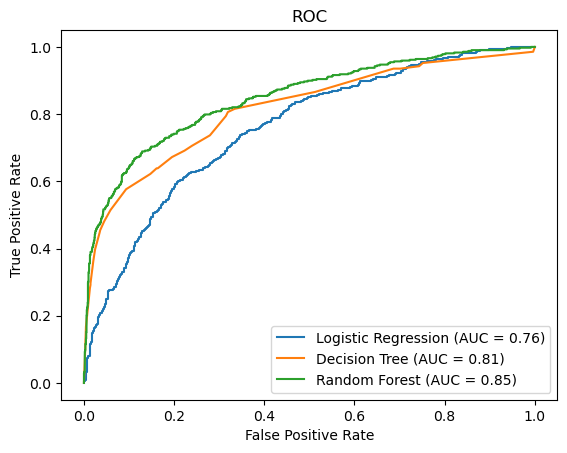

In [ ]:
# Вызываем предсказание вероятности классов
log_reg_probs = log_reg.predict_proba(features_valid)[:,1]
decision_tree_probs = decision_tree.predict_proba(features_valid)[:,1]
random_forest_probs = random_forest.predict_proba(features_valid)[:,1]

# Рассчитываем TPR и FPR для различных порогов
log_reg_fpr, log_reg_tpr, _ = roc_curve(target_valid, log_reg_probs)
decision_tree_fpr, decision_tree_tpr, _ = roc_curve(target_valid, decision_tree_probs)
random_forest_fpr, random_forest_tpr, _ = roc_curve(target_valid, random_forest_probs)

# считаем AUC для моделей
log_reg_auc = auc(log_reg_fpr, log_reg_tpr)
decision_tree_auc = auc(decision_tree_fpr, decision_tree_tpr)
random_forest_auc = auc(random_forest_fpr, random_forest_tpr)

# Строим график
plt.figure()
plt.plot(log_reg_fpr, log_reg_tpr, label='Logistic Regression (AUC = %0.2f)' % log_reg_auc)
plt.plot(decision_tree_fpr, decision_tree_tpr, label='Decision Tree (AUC = %0.2f)' % decision_tree_auc)
plt.plot(random_forest_fpr, random_forest_tpr, label='Random Forest (AUC = %0.2f)' % random_forest_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()


Посчитаем и визуализируем F1-меру моделей.

F1-мера модели Logistic Regression составляет: 0.3123
F1-мера модели Decision Tree составляет: 0.5667
F1-мера модели Random Forest составляет: 0.5750


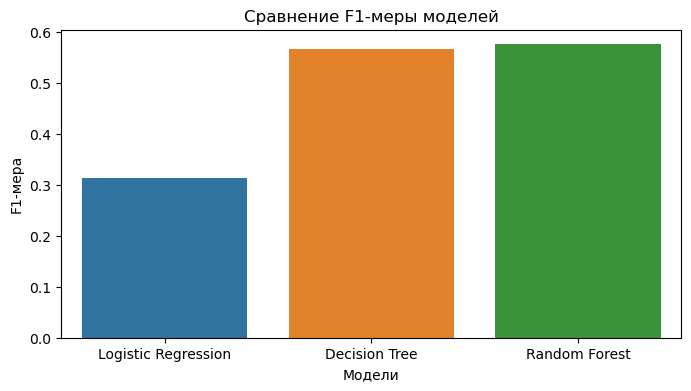

In [ ]:
# посчитаем F1-меру лог регрессии на валидационной выборке
log_reg_pred = log_reg.predict(features_valid)
log_reg_f1 = f1_score(target_valid, log_reg_pred)

# посчитаем F1-меру дерева решений на валидационной выборке
decision_tree_pred = decision_tree.predict(features_valid)
decision_tree_f1 = f1_score(target_valid, decision_tree_pred)

# посчитаем F1-меру случайного леса на валидационной выборке
random_forest_pred = random_forest.predict(features_valid)
random_forest_f1 = f1_score(target_valid, random_forest_pred)

# создадим словарь с результатами
models_f1 = {'Logistic Regression': log_reg_f1,
          'Decision Tree': decision_tree_f1,
          'Random Forest': random_forest_f1}

# выведем значения из словаря с помощью цикла
for model_name, f1 in models_f1.items():
    print(f"F1-мера модели {model_name} составляет: {f1:.4f}")

# построим барплот
plt.figure(figsize=(8,4))
sns.barplot(x=list(models_f1.keys()), y=list(models_f1.values()))
plt.xlabel('Модели')
plt.ylabel('F1-мера')
plt.title('Сравнение F1-меры моделей')
plt.show()

Лучший результат показала модель `RandomForestClassifier`.

** Промежуточный вывод:**
- Были исследованы три модели классификации, основанные на алгоритмах логистической регрессии, дерева решений и случайного леса.
- У каждой модели были подобраны гиперпараметры, оптимизирующие модель относительно F1-меры.
- После проведения оценки показателей эффективности моделей было определено, что модель случайного леса выдает наилучший результат как по метрике F1, так и по AUC.

Выше мы определяли, что в данных есть значительный дисбаланс классов. Исправим его и попробуем переобучить модель.

## Исправление дисбаланса

Для борьбы с несбалансированностью классов используем два метода: `downsampling` и `upsampling`.


Используем методы изменения рабзмера выборки, обучим модели с выбранными параметрами на этих данных и сравним результат на валидацинной выборке.

In [ ]:
#напишем функцию для уменьшения в тренировочной датасете данных большего класса

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_sample = features_zeros.sample(frac=fraction, random_state=1967)
    target_sample = target_zeros.sample(frac=fraction, random_state=1967)

    features_downsampled = pd.concat([features_sample] + [features_ones])
    target_downsampled = pd.concat([target_sample] + [target_ones])

    features_downsampled = shuffle(features_downsampled, random_state=1967)
    target_downsampled = shuffle(target_downsampled, random_state=1967)


    return features_downsampled, target_downsampled

#используем функцию на наших данных
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.249)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2392, 11)
(2392,)


Проверим, как распредилятся классы.

In [ ]:
target_downsampled.value_counts()

0    1196
1    1196
Name: Exited, dtype: int64

In [ ]:
#напишем функцию для уменьшения в тренировочной датасете данных меньшего класса

def upsample(features, target, repeat):

    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled = shuffle(features_upsampled, random_state=1967)
    target_upsampled = shuffle(target_upsampled, random_state=1967)

    return features_upsampled, target_upsampled



features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9588, 11)
(9588,)


In [ ]:
target_upsampled.value_counts()

0    4804
1    4784
Name: Exited, dtype: int64

Теперь обучим каждую модель 3 раза:
- на данных, обработанных методом upsample
- на данных, обработанных методом downsample
- используя гиперпараметр "balanced", который автоматически балансирует распределение весов классов

И выберем самую лучшую модель по метрикам AUC и ROC

## Обучения Logistic Regression

Создадим таблицу, куда будем записывать результаты наших тестов.

In [ ]:
models = ["Logistic Regression с upsample", "Logistic Regression с downsample", "Logistic Regression с class_weight", "Decission Tree с upsample", "Decission Tree с downsample", "Decission Tree с class_weight", "Random Forest с upsample", "Random Forest с downsample", "Random Forest с class_weight"]
model_competition = pd.DataFrame(models, columns=["Модель"])
model_competition["AUC"] = None
model_competition["F1"] = None
model_competition.style.set_properties(**{'text-align': 'left'})

model_competition

,Модель,AUC,F1
0,Logistic Regression с upsample,None,None
1,Logistic Regression с downsample,None,None
2,Logistic Regression с class_weight,None,None
3,Decission Tree с upsample,None,None
4,Decission Tree с downsample,None,None
5,Decission Tree с class_weight,None,None
6,Random Forest с upsample,None,None
7,Random Forest с downsample,None,None
8,Random Forest с class_weight,None,None


Перебирём гиперпараметры `Logistic Regression` с upsample.

In [ ]:
penalties = ['l1', 'l2', 'elasticnet', None]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
C_values = [0.1, 0.2, 0.5, 1, 10, 100, 150]

best_f1 = 0
best_penalty = None
best_solver = None
best_C = None
counter = 0

for penalty in penalties:
    for solver in solvers:
        for C in C_values:
            try:
                model = LogisticRegression(penalty=penalty, solver=solver, C=C, random_state=1967)
                model.fit(features_upsampled, target_upsampled)
                target_pred = model.predict(features_valid)
                f1 = f1_score(target_valid, target_pred)
                counter += 1
                if f1 > best_f1:
                    best_f1 = f1
                    best_penalty = penalty
                    best_solver = solver
                    best_C = C
                    log_reg_up = model
            except:
                pass


In [ ]:
#делаем предсказание модели и считаем f1-меру
log_reg_up_pred = log_reg_up.predict(features_valid)
log_reg_up_f1 = f1_score(target_valid, log_reg_up_pred)

# считаем AUC для модели
log_reg_up_probs = log_reg_up.predict_proba(features_valid)[:,1]
log_reg_up_fpr, log_reg_up_tpr, _ = roc_curve(target_valid, log_reg_up_probs)
log_reg_up_auc = auc(log_reg_up_fpr, log_reg_up_tpr)

#запишем данные в таблицу
model_competition.at[0, "AUC"] = log_reg_up_auc
model_competition.at[0, "F1"] = log_reg_up_f1

model_competition

,Модель,AUC,F1
0,Logistic Regression с upsample,0.763814,0.493461
1,Logistic Regression с downsample,None,None
2,Logistic Regression с class_weight,None,None
3,Decission Tree с upsample,None,None
4,Decission Tree с downsample,None,None
5,Decission Tree с class_weight,None,None
6,Random Forest с upsample,None,None
7,Random Forest с downsample,None,None
8,Random Forest с class_weight,None,None


Перебирём гиперпараметры Logistic Regression с `downsample`. Посчитаем метрики данной модели и запишем данные в таблицу.

In [ ]:
penalties = ['l1', 'l2', 'elasticnet', None]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
C_values = [0.1, 0.2, 0.5, 1, 10, 100, 150]

best_f1 = 0
best_penalty = None
best_solver = None
best_C = None
counter = 0

for penalty in penalties:
    for solver in solvers:
        for C in C_values:
            try:
                model = LogisticRegression(penalty=penalty, solver=solver, C=C, random_state=1967)
                model.fit(features_downsampled, target_downsampled)
                target_pred = model.predict(features_valid)
                f1 = f1_score(target_valid, target_pred)
                counter += 1
                if f1 > best_f1:
                    best_f1 = f1
                    best_penalty = penalty
                    best_solver = solver
                    best_C = C
                    log_reg_down = model
            except:
                pass

In [ ]:
#делаем предсказание модели и считаем f1-меру
log_reg_down_pred = log_reg_down.predict(features_valid)
log_reg_down_f1 = f1_score(target_valid, log_reg_down_pred)

# считаем AUC для модели
log_reg_down_probs = log_reg_down.predict_proba(features_valid)[:,1]
log_reg_down_fpr, log_reg_down_tpr, _ = roc_curve(target_valid, log_reg_down_probs)
log_reg_down_auc = auc(log_reg_down_fpr, log_reg_down_tpr)

model_competition.at[1, "AUC"] = log_reg_down_auc
model_competition.at[1, "F1"] = log_reg_down_f1

model_competition

,Модель,AUC,F1
0,Logistic Regression с upsample,0.763814,0.493461
1,Logistic Regression с downsample,0.763162,0.492498
2,Logistic Regression с class_weight,None,None
3,Decission Tree с upsample,None,None
4,Decission Tree с downsample,None,None
5,Decission Tree с class_weight,None,None
6,Random Forest с upsample,None,None
7,Random Forest с downsample,None,None
8,Random Forest с class_weight,None,None


Перебирём гиперпараметры Logistic Regression с balanced. Посчитаем метрики данной модели и запишем данные в таблицу.

In [ ]:
penalties = ['l1', 'l2', 'elasticnet', None]
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
C_values = [0.1, 0.2, 0.5, 1, 10, 100, 150]

best_f1 = 0
best_penalty = None
best_solver = None
best_C = None
counter = 0

for penalty in penalties:
    for solver in solvers:
        for C in C_values:
            try:
                model = LogisticRegression(penalty=penalty, solver=solver, C=C, random_state=1967, class_weight='balanced')
                model.fit(features_train, target_train)
                target_pred = model.predict(features_valid)
                f1 = f1_score(target_valid, target_pred)
                counter += 1
                if f1 > best_f1:
                    best_f1 = f1
                    best_penalty = penalty
                    best_solver = solver
                    best_C = C
                    log_reg_balansed = model
            except:
                pass

In [ ]:
#делаем предсказание модели и считаем f1-меру
log_reg_balansed_pred = log_reg_balansed.predict(features_valid)
log_reg_balansed_f1 = f1_score(target_valid, log_reg_balansed_pred)

# считаем AUC для модели
log_reg_balansed_probs = log_reg_balansed.predict_proba(features_valid)[:,1]
log_reg_balansed_fpr, log_reg_balansed_tpr, _ = roc_curve(target_valid, log_reg_balansed_probs)
log_reg_balansed_auc = auc(log_reg_balansed_fpr, log_reg_balansed_tpr)

model_competition.at[2, "AUC"] = log_reg_balansed_auc
model_competition.at[2, "F1"] = log_reg_balansed_f1

model_competition

,Модель,AUC,F1
0,Logistic Regression с upsample,0.763814,0.493461
1,Logistic Regression с downsample,0.763162,0.492498
2,Logistic Regression с class_weight,0.764177,0.493913
3,Decission Tree с upsample,None,None
4,Decission Tree с downsample,None,None
5,Decission Tree с class_weight,None,None
6,Random Forest с upsample,None,None
7,Random Forest с downsample,None,None
8,Random Forest с class_weight,None,None


Обучили три модели Logistic Regression. Сами модели между собой отличаются незначительно. Но если сравнить их с моделями, где не учитывался дисбаланс классов, то улучшение F1-меры значительно.
- Лучший результат без обработки дисбаланса: AUC 0.76, **F1 0.31**
- Лучшие результат после обработки: AUC 0.76, **F1 0.49**

## Обучаем Decission Tree

Обучим модель дерева решений и перибаем гипермараметр max_depth на данных upsampling, оптимизируя его по AUC. Метрики модели всех трех тестов измерим и запишем в таблицу.

In [ ]:
#находим лучший гиперпараметр
best_depth = None
best_score = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=1967, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    target_pred = model.predict(features_valid)
    score = f1_score(target_valid, target_pred)
    if score > best_score:
        best_depth = depth
        decision_tree_up = model


#делаем предсказание модели и считаем f1-меру
decision_tree_up_pred = decision_tree_up.predict(features_valid)
decision_tree_up_f1 = f1_score(target_valid, decision_tree_up_pred)

# считаем AUC для модели
decision_tree_up_probs = decision_tree_up.predict_proba(features_valid)[:,1]
decision_tree_up_fpr, decision_tree_up_tpr, _ = roc_curve(target_valid, decision_tree_up_probs)
decision_tree_up_auc = auc(decision_tree_up_fpr, decision_tree_up_tpr)

model_competition.at[3, "AUC"] = decision_tree_up_auc
model_competition.at[3, "F1"] = decision_tree_up_f1

model_competition


,Модель,AUC,F1
0,Logistic Regression с upsample,0.763814,0.493461
1,Logistic Regression с downsample,0.763162,0.492498
2,Logistic Regression с class_weight,0.764177,0.493913
3,Decission Tree с upsample,0.766636,0.539841
4,Decission Tree с downsample,None,None
5,Decission Tree с class_weight,None,None
6,Random Forest с upsample,None,None
7,Random Forest с downsample,None,None
8,Random Forest с class_weight,None,None


In [ ]:
best_depth = None
best_score = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=1967, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    target_pred = model.predict(features_valid)
    score = f1_score(target_valid, target_pred)
    if score > best_score:
        best_depth = depth
        decision_tree_down = model


#делаем предсказание модели и считаем f1-меру
decision_tree_down_pred = decision_tree_down.predict(features_valid)
decision_tree_down_f1 = f1_score(target_valid, decision_tree_down_pred)

# считаем AUC для модели
decision_tree_down_probs = decision_tree_down.predict_proba(features_valid)[:,1]
decision_tree_down_fpr, decision_tree_down_tpr, _ = roc_curve(target_valid, decision_tree_down_probs)
decision_tree_down_auc = auc(decision_tree_down_fpr, decision_tree_down_tpr)

model_competition.at[4, "AUC"] = decision_tree_down_auc
model_competition.at[4, "F1"] = decision_tree_down_f1

model_competition

,Модель,AUC,F1
0,Logistic Regression с upsample,0.763814,0.493461
1,Logistic Regression с downsample,0.763162,0.492498
2,Logistic Regression с class_weight,0.764177,0.493913
3,Decission Tree с upsample,0.766636,0.539841
4,Decission Tree с downsample,0.754172,0.511265
5,Decission Tree с class_weight,None,None
6,Random Forest с upsample,None,None
7,Random Forest с downsample,None,None
8,Random Forest с class_weight,None,None


In [ ]:
best_depth = None
best_score = 0
for depth in range(1, 10):
    model = DecisionTreeClassifier(random_state=1967, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    target_pred = model.predict(features_valid)
    score = f1_score(target_valid, target_pred)
    if score > best_score:
        best_depth = depth
        decision_tree_balanced = model


#делаем предсказание модели и считаем f1-меру
decision_tree_balanced_pred = decision_tree_balanced.predict(features_valid)
decision_tree_balanced_f1 = f1_score(target_valid, decision_tree_balanced_pred)

# считаем AUC для модели
decision_tree_balanced_probs = decision_tree_balanced.predict_proba(features_valid)[:,1]
decision_tree_balanced_fpr, decision_tree_balanced_tpr, _ = roc_curve(target_valid, decision_tree_balanced_probs)
decision_tree_balanced_auc = auc(decision_tree_balanced_fpr, decision_tree_balanced_tpr)

model_competition.at[5, "AUC"] = decision_tree_balanced_auc
model_competition.at[5, "F1"] = decision_tree_balanced_f1

model_competition


,Модель,AUC,F1
0,Logistic Regression с upsample,0.763814,0.493461
1,Logistic Regression с downsample,0.763162,0.492498
2,Logistic Regression с class_weight,0.764177,0.493913
3,Decission Tree с upsample,0.766636,0.539841
4,Decission Tree с downsample,0.754172,0.511265
5,Decission Tree с class_weight,0.76563,0.539461
6,Random Forest с upsample,None,None
7,Random Forest с downsample,None,None
8,Random Forest с class_weight,None,None


**Обучили три модели Decission Tree**.
- По сравнению с логистической регрессией модель дерева решений лучше справилась с метриков F1
- Лучший результатат снова показала модель используящая метод `class_weight=balanced`

Если сравнивать модель до и после обработки дисбаланса, то после обоработки дисбаланса показатели обеих метрик стали ниже.
- Лучший результат без обработки дисбаланса: **AUC 0.81**, F1 0.57
- Лучшие результат после обработки: **AUC 0.77**, F1 0.54

Повторим такое же обучение для модели Random Forest.

### Random Forest

Обучим модель случайного. Метрики модели всех трех тестов измерим и запишем в таблицу.

In [ ]:
best_score = 0
for est in range(10, 100, 10):
    for depth in range(1,10):
        model = RandomForestClassifier(random_state=1967, n_estimators=est, max_depth=depth) # обучите модель с заданным количеством деревьев
        model.fit(features_upsampled, target_upsampled) # обучите модель на тренировочной выборке
        target_pred = model.predict(features_valid)
        score = f1_score(target_valid, target_pred)
        if score > best_score:
            best_depth = depth
            best_score = score
            best_est=est

random_forest_up = RandomForestClassifier(random_state=1967, n_estimators=best_est, max_depth=best_depth)
random_forest_up.fit(features_upsampled, target_upsampled)


#делаем предсказание модели и считаем f1-меру
random_forest_up_pred = random_forest_up.predict(features_valid)
random_forest_up_f1 = f1_score(target_valid, random_forest_up_pred)

# считаем AUC для модели
random_forest_up_probs = random_forest_up.predict_proba(features_valid)[:,1]
random_forest_up_fpr, random_forest_up_tpr, _ = roc_curve(target_valid, random_forest_up_probs)
random_forest_up_auc = auc(random_forest_up_fpr, random_forest_up_tpr)

model_competition.at[6, "AUC"] = random_forest_up_auc
model_competition.at[6, "F1"] = random_forest_up_f1

model_competition

,Модель,AUC,F1
0,Logistic Regression с upsample,0.763814,0.493461
1,Logistic Regression с downsample,0.763162,0.492498
2,Logistic Regression с class_weight,0.764177,0.493913
3,Decission Tree с upsample,0.766636,0.539841
4,Decission Tree с downsample,0.754172,0.511265
5,Decission Tree с class_weight,0.76563,0.539461
6,Random Forest с upsample,0.85361,0.61792
7,Random Forest с downsample,None,None
8,Random Forest с class_weight,None,None


In [ ]:
best_score = 0
for est in range(10, 100, 10):
    for depth in range(1,10):
            model = RandomForestClassifier(random_state=1967, n_estimators=est, max_depth=depth) # обучите модель с заданным количеством деревьев
            model.fit(features_downsampled, target_downsampled) # обучите модель на тренировочной выборке
            target_pred = model.predict(features_valid)
            score = f1_score(target_valid, target_pred)
            if score > best_score:
                best_depth = depth
                best_score = score
                best_est=est
                random_forest_down = model


#делаем предсказание модели и считаем f1-меру
random_forest_down_pred = random_forest_down.predict(features_valid)
random_forest_down_f1 = f1_score(target_valid, random_forest_down_pred)

# считаем AUC для модели
random_forest_down_probs = random_forest_down.predict_proba(features_valid)[:,1]
random_forest_down_fpr, random_forest_down_tpr, _ = roc_curve(target_valid, random_forest_down_probs)
random_forest_down_auc = auc(random_forest_down_fpr, random_forest_down_tpr)

model_competition.at[7, "AUC"] = random_forest_down_auc
model_competition.at[7, "F1"] = random_forest_down_f1

model_competition


,Модель,AUC,F1
0,Logistic Regression с upsample,0.763814,0.493461
1,Logistic Regression с downsample,0.763162,0.492498
2,Logistic Regression с class_weight,0.764177,0.493913
3,Decission Tree с upsample,0.766636,0.539841
4,Decission Tree с downsample,0.754172,0.511265
5,Decission Tree с class_weight,0.76563,0.539461
6,Random Forest с upsample,0.85361,0.61792
7,Random Forest с downsample,0.850239,0.603664
8,Random Forest с class_weight,None,None


In [ ]:
best_score = 0
for est in range(10, 100, 10):
    for depth in range(1,10):
            model = RandomForestClassifier(random_state=1967, n_estimators=est, max_depth=depth, class_weight='balanced') # обучите модель с заданным количеством деревьев
            model.fit(features_train, target_train)
            target_pred = model.predict(features_valid)
            score = f1_score(target_valid, target_pred)
            if score > best_score:
                best_depth = depth
                best_score = score
                best_est=est
                random_forest_balanced = model


#делаем предсказание модели и считаем f1-меру
random_forest_balanced_pred = random_forest_balanced.predict(features_valid)
random_forest_balanced_f1 = f1_score(target_valid, random_forest_balanced_pred)
print(random_forest_balanced_f1)

# считаем AUC для модели
random_forest_balanced_probs = random_forest_balanced.predict_proba(features_valid)[:,1]
random_forest_balanced_fpr, random_forest_balanced_tpr, _ = roc_curve(target_valid, random_forest_balanced_probs)
random_forest_balanced_auc = auc(random_forest_balanced_fpr, random_forest_balanced_tpr)


model_competition.at[8, "AUC"] = random_forest_balanced_auc
model_competition.at[8, "F1"] = random_forest_balanced_f1

model_competition



0.6276243093922652


,Модель,AUC,F1
0,Logistic Regression с upsample,0.763814,0.493461
1,Logistic Regression с downsample,0.763162,0.492498
2,Logistic Regression с class_weight,0.764177,0.493913
3,Decission Tree с upsample,0.766636,0.539841
4,Decission Tree с downsample,0.754172,0.511265
5,Decission Tree с class_weight,0.76563,0.539461
6,Random Forest с upsample,0.85361,0.61792
7,Random Forest с downsample,0.850239,0.603664
8,Random Forest с class_weight,0.85595,0.627624


**Обучили три модели Random Forest**.

- модель с Random Forest показала лучшие результаты среди всех моделей в этом проекте!
- лучшие показатели у модели используещие гиперпараметр `class_weight` со значением `balanced`
- если сравнивать с моделями до обработки дисбаланса, то метрика f1 тоже выросла:
- - Лучший результат без обработки дисбаланса: AUC 0.85, F1 0.57
- - Лучший результат после обработки: AUC 0.85, F1 **0.63**


Посмотрим еще раз на сравнение моделей.

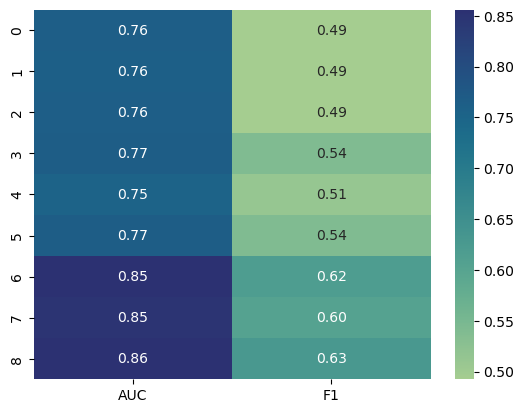

In [ ]:
hitmap = model_competition[['AUC', 'F1']].astype(float)
sns.heatmap(hitmap, annot=True, cmap='crest', fmt='.2f')
plt.show()

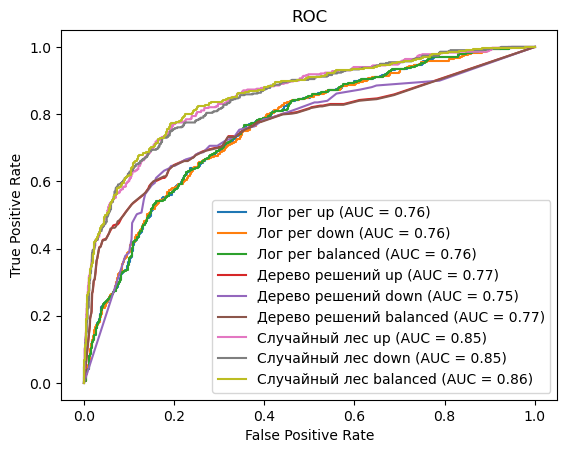

In [ ]:
plt.figure()

plt.plot(log_reg_up_fpr, log_reg_up_tpr, label='Лог рег up (AUC = %0.2f)' % log_reg_up_auc)
plt.plot(log_reg_down_fpr, log_reg_down_tpr, label='Лог рег down (AUC = %0.2f)' % log_reg_balansed_auc)
plt.plot(log_reg_balansed_fpr, log_reg_balansed_tpr, label='Лог рег balanced (AUC = %0.2f)' % log_reg_balansed_auc)
plt.plot(decision_tree_up_fpr, decision_tree_up_tpr, label='Дерево решений up (AUC = %0.2f)' % decision_tree_up_auc)
plt.plot(decision_tree_down_fpr, decision_tree_down_tpr, label='Дерево решений down (AUC = %0.2f)' % decision_tree_down_auc)
plt.plot(decision_tree_balanced_fpr, decision_tree_balanced_tpr, label='Дерево решений balanced (AUC = %0.2f)' % decision_tree_balanced_auc)
plt.plot(random_forest_up_fpr, random_forest_up_tpr, label='Случайный лес up (AUC = %0.2f)' % random_forest_up_auc)
plt.plot(random_forest_down_fpr, random_forest_down_tpr, label='Случайный лес down (AUC = %0.2f)' % random_forest_down_auc)
plt.plot(random_forest_balanced_fpr, random_forest_balanced_tpr, label='Случайный лес balanced (AUC = %0.2f)' % random_forest_balanced_auc)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.show()

**Промежуточные выводы:**
- Мы использовали два метода, чтобы уменьшить влияние дисбаланса классов: метод `upsamling` и `downsampling`.
- Мы обучили три модели тремя разными способами: на уменьшенной, увеличенной выборке и с использованием встроенного метода class_weight
- У каждой модели мы перебрали сновные гиперпараметры, чтобы обнаружить лучшую модель
- Мы проанализировали результаты и выбрали лучшую модель. Ей оказалась модель random forest, использующая class_weight=balanced

## Проверка модели на тестовой выборке

Проверим модель на тестовой выборки и оценим метрики `accuracy`,`F1`,`ROC-AUC`

In [ ]:
model_final = random_forest_balanced
model_final.fit(features_train, target_train)
pred = model_final.predict(features_test)

model_final_probs = model_final.predict_proba(features_test)[:,1]
model_final_fpr, model_final_tpr, _ = roc_curve(target_test, model_final_probs)
model_final_auc = auc(model_final_fpr, model_final_tpr)

print("F1 Accuracy модели:",model_final.score(features_test, target_test))
print("F1 модели:",f1_score(target_test, pred))
print("AUC:",model_final_auc)

F1 Accuracy модели: 0.8185
F1 модели: 0.6058631921824104
AUC: 0.8570826793549712


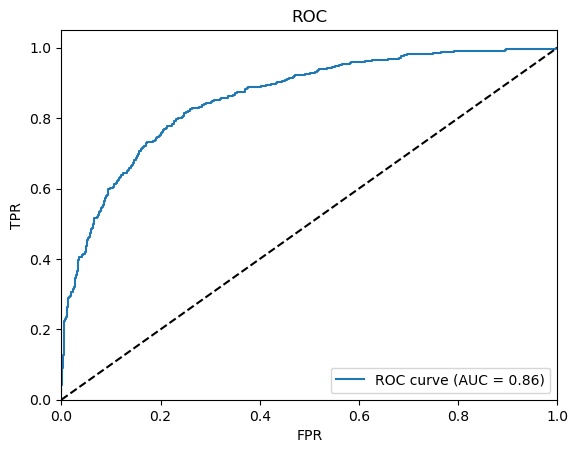

''

In [ ]:
pred_proba = model_final.predict_proba(features_test)
pred_proba_class_1 = pred_proba[:, 1]

# Вычисляем ROC-кривую
fpr, tpr, _ = roc_curve(target_test, pred_proba_class_1)

# Вычисляем AUC
roc_auc = roc_auc_score(target_test, pred_proba_class_1)

# Выводим результаты
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()
;

**Результат финальной модели**:
- **Accuracy**  модели: 0.81
- **F1** модели: 0.61
- **AUC**: 0.86

Оценим вклад каждого признака в предсказание нашей модели.

In [ ]:
importances = model_final.feature_importances_
feature_importance = pd.DataFrame({"feature": features_train.columns, "importance": importances})
feature_importance.sort_values("importance", ascending=False, inplace=True)
feature_importance


,feature,importance
1,Age,0.348604
4,NumOfProducts,0.216392
3,Balance,0.107265
6,IsActiveMember,0.069209
8,Geography_Germany,0.062273
0,CreditScore,0.059464
7,EstimatedSalary,0.059129
2,Tenure,0.032236
10,Gender_Male,0.028512
5,HasCrCard,0.010021


Как мы уже выяснили выше, возраст — самая важная характеристика для предсказания!

## Выводы

Нам была предоставлена историческая информация о поведении клиентов и расторжении договоров с банком.
<p>В ходе исследования мы:</p>

- Изучили полученную информацию и обнаружили некоторые закономерности, такие как влияние возраста и страны на прогноз.
- Провели предобработку данных: удалили лишние данные, кодировали категориальные переменные. Также мы масштабировали данные и разбили их на три выборки: обучающую, валидационную и тестовую.
- Обучили три модели (логистическая регрессия, дерево решений и случайный леа) на данных с дисбалансом классов и оптимизировали их гиперпараметры.
- Исправили дисбаланс классов с помощью методов апсемплинга и даунсемплинга.
- Каждую из трех моделей обучили тремя разными способами: на выборке обработанной апсемплингом, на выборке обработанной даунсемплинга и с помощью встроенного метода библиотеки sklearn. Для каждой модели оптимизировали гиперпараметры по метрике f1.
- Таки образом, получили 9 моделей, каждую из которых оценили по метрикам F1 и AUC. Выбрали лучшую модель, ею оказалась модель random forest, использующая class_weight=balanced

- Проверили лучшую модель на тестовой выборке и получи следующие показатели:
- - `Аccuracy` модели: 0.82
- - `F1` модели: 0.61
- - `AUC`: 0.86
- В конце мы исследовали вклад каждого признака в результаты нашей модели. Самые важные для прогноза призанки: `Age`, `NumOfProducts`, `Balance`


